In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

In [2]:
datasetss = fetch_20newsgroups(subset='train')

In [3]:
datasetss = ['sci.med','comp.graphics']
dataset = fetch_20newsgroups(subset='train', categories=datasetss)

In [4]:
print('Training data size:', len(dataset['data']))

Training data size: 1178


finding frequency for each category

In [5]:
targets, frequency = np.unique(dataset.target, return_counts=True)
targets, frequency

(array([0, 1]), array([584, 594]))

In [6]:
targets_str = np.array(dataset.target_names)
print(list(zip(targets_str, frequency)))

[('comp.graphics', 584), ('sci.med', 594)]


Distribution of training data

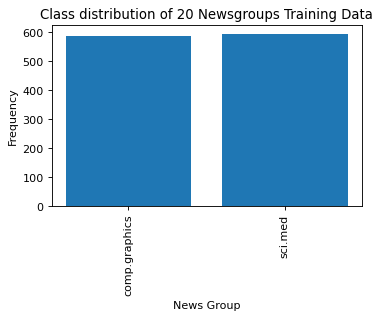

In [7]:
fig=plt.figure(figsize=(5, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets_str,frequency)
plt.xticks(rotation=90)
plt.title('Class distribution of 20 Newsgroups Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

Data preprocessing and preparation and converting to dataframe to work with

In [8]:
dataset_df = pd.DataFrame({'data': dataset.data, 'target': dataset.target})
dataset_df.head()

,data,target
0,From: zyeh@caspian.usc.edu (zhenghao yeh)\nSub...,0
1,From: jim.zisfein@factory.com (Jim Zisfein) \n...,1
2,From: stefan@lis.e-technik.tu-muenchen.de (Ste...,0
3,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,1
4,From: ranjan@cs.ubc.ca (Vishwa Ranjan)\nSubjec...,0


Removing punctuations and converting all alpabets to lower case 

In [9]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

dataset_df['data'] = dataset_df.data.map(alphanumeric).map(punc_lower)
dataset_df.head()

,data,target
0,from zyeh caspian usc edu zhenghao yeh \nsub...,0
1,from jim zisfein factory com jim zisfein \n...,1
2,from stefan lis e technik tu muenchen de ste...,0
3,from dougb comm mot com doug bank \nsubject ...,1
4,from ranjan cs ubc ca vishwa ranjan \nsubjec...,0


Removing stop words with count vectorizer and implementing Bag of Words

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')

dataset_new = count_vect.fit_transform(dataset_df.data)  # fit_transform learns the vocab and one-hot encodes

print(dataset_new.shape)
print(type(dataset_new))

(1178, 20602)
<class 'scipy.sparse.csr.csr_matrix'>


3) Implementing a TF-IDF feature representation for each text sample

In [11]:
# Creating a document-term matrix using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfV = TfidfVectorizer(stop_words='english') 
# tfidfV = TfidfVectorizer(ngram_range=(1, 2), binary =True, stop_words='english') 

dataset_tfidfV = tfidfV.fit_transform(dataset_df.data).toarray() # fit_transform learns the vocab and one-hot encodes 

# print the dimensions of the training set 
print(dataset_tfidfV.shape)
print(type(dataset_tfidfV))

(1178, 20602)
<class 'numpy.ndarray'>


Splitting the datasets into train, test and validation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_tfidfV, dataset.target, test_size=0.1, random_state=3116)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=3116)


In [19]:
class MultinomialNB():
    def __init__(self, alpha=1):
        self.alpha = alpha 

    def fit(self, X_train, y_train):
        m, n = X_train.shape
        self._classes = np.unique(y_train)
        n_classes = len(self._classes)

        # init: Prior & Likelihood
        self._priors = np.zeros(n_classes)
        self._likelihoods = np.zeros((n_classes, n))

       # Get Prior and Likelihood
        for idx, c in enumerate(self._classes):
            X_train_c = X_train[c == y_train]
            self._priors[idx] = X_train_c.shape[0] / m 
            self._likelihoods[idx, :] = ((X_train_c.sum(axis=0)) + self.alpha) / (np.sum(X_train_c.sum(axis=0) + self.alpha))
    def predict(self, X_test):
        return [self._predict(x_test) for x_test in X_test]    

    def _predict(self, x_test):
    # Calculate posterior for each class
        posteriors = []
        for idx, c in enumerate(self._classes):
            prior_c = np.log(self._priors[idx])
            likelihoods_c = self.calc_likelihood(self._likelihoods[idx,:], x_test)
            posteriors_c = np.sum(likelihoods_c) + prior_c
            posteriors.append(posteriors_c)

        return self._classes[np.argmax(posteriors)]
    def calc_likelihood(self, cls_likeli, x_test):
        return np.log(cls_likeli) * x_test

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.sum(y_pred == y_test)/len(y_test)

 




In [20]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

In [21]:
ypred_MNB=classifier.predict(X_test)


In [23]:
print (ypred_MNB)

[0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [25]:
from sklearn.metrics import classification_report, accuracy_score 
print(accuracy_score(y_test, ypred_MNB))
print(classification_report(y_test, ypred_MNB))

0.9745762711864406
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        56
           1       0.98      0.97      0.98        62

    accuracy                           0.97       118
   macro avg       0.97      0.97      0.97       118
weighted avg       0.97      0.97      0.97       118



In [26]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', gamma= 'scale', random_state = 3116)
svm.fit(X_val, y_val)

SVC(kernel='linear', random_state=3116)

In [28]:
y_pred_svm = svm.predict(X_test)
print(accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

0.9152542372881356
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        56
           1       1.00      0.84      0.91        62

    accuracy                           0.92       118
   macro avg       0.92      0.92      0.92       118
weighted avg       0.93      0.92      0.92       118



Comparing both model accuracies on a boxplot

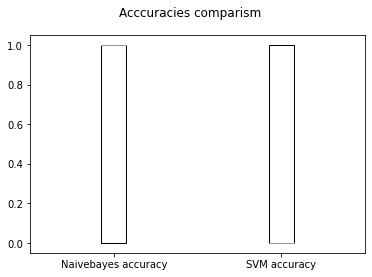

In [29]:
results = [ypred_MNB,y_pred_svm]
names = ['Naivebayes accuracy','SVM accuracy']
fig = plt.figure()
fig.suptitle('Acccuracies comparism ')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



## REPORT:
From both models we can see I acheived a higher accuracy on my Naivebayes Model than my SVM model, this might be because the NaiveBayes model had more data to train with than the SVM model which only trained with my validation split but overall both model performed well which is as a result of text preproccessing and stop words removal.